In [2]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/image_super_resolution/image_super_resolution.zip
!unzip -qq image_super_resolution.zip
%cd image_super_resolution

!wget https://pis-datasets.s3.us-east-2.amazonaws.com/ukbench100.zip
!unzip -qq ukbench100.zip

--2022-05-04 02:35:59--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/image_super_resolution/image_super_resolution.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.132.234
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.132.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1050845 (1.0M) [binary/octet-stream]
Saving to: ‘image_super_resolution.zip’

image_super_resolut 100%[===================>]   1.00M  1.50MB/s    in 0.7s    

2022-05-04 02:36:00 (1.50 MB/s) - ‘image_super_resolution.zip’ saved [1050845/1050845]

/content/image_super_resolution
--2022-05-04 02:36:00--  https://pis-datasets.s3.us-east-2.amazonaws.com/ukbench100.zip
Resolving pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)... 52.219.88.152
Connecting to pis-datasets.s

In [3]:
# Importing Libraries
import numpy as np
import shutil
import h5py
import cv2
import PIL
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from imutils import paths
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam

def display(title, img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (12, 12))
  plt.imshow(img)
  plt.title(title)
  plt.grid(False)
  plt.show()

In [4]:
##################### GENERATING CUSTOM CONFIGURATION ##################### (Referenced from existing documentation)
class Config:
    # define the path to the input images we will be using to build the
    # training crops
    INPUT_IMAGES = "ukbench100"

    # define the path to the temporary output directories
    BASE_OUTPUT = "output"
    IMAGES = os.path.sep.join([BASE_OUTPUT, "images"])
    LABELS = os.path.sep.join([BASE_OUTPUT, "labels"])

    # define the path to the HDF5 files
    INPUTS_DB = os.path.sep.join([BASE_OUTPUT, "inputs.hdf5"])
    OUTPUTS_DB = os.path.sep.join([BASE_OUTPUT, "outputs.hdf5"])

    # define the path to the output model file and the plot file
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "srcnn.model"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

    # initialize the batch size and number of epochs for training
    BATCH_SIZE = 128
    NUM_EPOCHS = 50

    # initialize the scale (the factor in which we want to learn how to
    # enlarge images by) along with the input width and height dimensions
    # to our SRCNN
    SCALE = 2.0
    INPUT_DIM = 33

    # the label size should be the output spatial dimensions of the SRCNN
    # while our padding ensures we properly crop the label ROI
    LABEL_SIZE = 21
    PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)

    # the stride controls the step size of our sliding window
    STRIDE = 14

config = Config()

##################### HDF5 DATASET WRITER ##################### (Referenced from existing documentation)

class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",
        bufSize=1000):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied `outputPath` already "
                "exists and cannot be overwritten. Manually delete "
                "the file before continuing.", outputPath)

        # open the HDF5 database for writing and create two datasets:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,
            dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],),
            dtype="int")

        # store the buffer size, then initialize the buffer itself
        # along with the index into the datasets
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str) # `vlen=unicode` for Py2.7
        labelSet = self.db.create_dataset("label_names",
            (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):
        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

##################### Dataset Builder Section ##################### (Referenced from existing documentation)

# if the output directories do not exist, create them
for p in [config.IMAGES, config.LABELS]:
	if not os.path.exists(p):
		os.makedirs(p)

# grab the image paths and initialize the total number of crops
# processed
print("[INFO] creating temporary images...")
imagePaths = list(paths.list_images(config.INPUT_IMAGES))
random.shuffle(imagePaths)
total = 0

# loop over the image paths
for imagePath in imagePaths:
	# load the input image
	image = cv2.imread(imagePath)

	# grab the dimensions of the input image and crop the image such
	# that it tiles nicely when we generate the training data +
	# labels
	(h, w) = image.shape[:2]
	w -= int(w % config.SCALE)
	h -= int(h % config.SCALE)
	image = image[0:h, 0:w]

	# to generate our training images we first need to downscale the
	# image by the scale factor...and then upscale it back to the
	# original size -- this will process allows us to generate low
	# resolution inputs that we'll then learn to reconstruct the high
	# resolution versions from
	lowW = int(w * (1.0 / config.SCALE))
	lowH = int(h * (1.0 / config.SCALE))
	highW = int(lowW * (config.SCALE / 1.0))
	highH = int(lowH * (config.SCALE / 1.0))

	# perform the actual scaling
	scaled = np.array(Image.fromarray(image).resize((lowW, lowH),
		resample=PIL.Image.BICUBIC))
	scaled = np.array(Image.fromarray(scaled).resize((highW, highH),
		resample=PIL.Image.BICUBIC))

	# slide a window from left-to-right and top-to-bottom
	for y in range(0, h - config.INPUT_DIM + 1, config.STRIDE):
		for x in range(0, w - config.INPUT_DIM + 1, config.STRIDE):
			# crop output the `INPUT_DIM x INPUT_DIM` ROI from our
			# scaled image -- this ROI will serve as the input to our
			# network
			crop = scaled[y:y + config.INPUT_DIM,
				x:x + config.INPUT_DIM]

			# crop out the `LABEL_SIZE x LABEL_SIZE` ROI from our
			# original image -- this ROI will be the target output
			# from our network
			target = image[
				y + config.PAD:y + config.PAD + config.LABEL_SIZE,
				x + config.PAD:x + config.PAD + config.LABEL_SIZE]

			# construct the crop and target output image paths
			cropPath = os.path.sep.join([config.IMAGES,
				"{}.png".format(total)])
			targetPath = os.path.sep.join([config.LABELS,
				"{}.png".format(total)])

			# write the images to disk
			cv2.imwrite(cropPath, crop)
			cv2.imwrite(targetPath, target)

			# increment the crop total
			total += 1

# grab the paths to the images
print("[INFO] building HDF5 datasets...")
inputPaths = sorted(list(paths.list_images(config.IMAGES)))
outputPaths = sorted(list(paths.list_images(config.LABELS)))

# initialize the HDF5 datasets
inputWriter = HDF5DatasetWriter((len(inputPaths), config.INPUT_DIM,
    config.INPUT_DIM, 3), config.INPUTS_DB)
outputWriter = HDF5DatasetWriter((len(outputPaths),
    config.LABEL_SIZE, config.LABEL_SIZE, 3), config.OUTPUTS_DB)

# loop over the images
for (inputPath, outputPath) in zip(inputPaths, outputPaths):
    # load the two images and add them to their respective datasets
    inputImage = cv2.imread(inputPath)
    outputImage = cv2.imread(outputPath)
    inputWriter.add([inputImage], [-1])
    outputWriter.add([outputImage], [-1])

# close the HDF5 datasets
inputWriter.close()
outputWriter.close()

# delete the temporary output directories
print("[INFO] cleaning up...")
shutil.rmtree(config.IMAGES)
shutil.rmtree(config.LABELS)

##################### HDF5 DATASET Generator ##################### (Referenced from existing documentation)

class HDF5DatasetGenerator:
    def __init__(self, dbPath, batchSize, preprocessors=None,
        aug=None, binarize=True, classes=2):
        # store the batch size, preprocessors, and data augmentor,
        # whether or not the labels should be binarized, along with
        # the total number of classes
        self.batchSize = batchSize
        self.preprocessors = preprocessors
        self.aug = aug
        self.binarize = binarize
        self.classes = classes

        # open the HDF5 database for reading and determine the total
        # number of entries in the database
        self.db = h5py.File(dbPath, "r")
        self.numImages = self.db["labels"].shape[0]

    def generator(self, passes=np.inf):
        # initialize the epoch count
        epochs = 0

        # keep looping infinitely -- the model will stop once we have
        # reach the desired number of epochs
        while epochs < passes:
            # loop over the HDF5 dataset
            for i in np.arange(0, self.numImages, self.batchSize):
                # extract the images and labels from the HDF dataset
                images = self.db["images"][i: i + self.batchSize]
                labels = self.db["labels"][i: i + self.batchSize]

                # check to see if the labels should be binarized
                if self.binarize:
                    labels = to_categorical(labels,
                        self.classes)

                # check to see if our preprocessors are not None
                if self.preprocessors is not None:
                    # initialize the list of processed images
                    procImages = []

                    # loop over the images
                    for image in images:
                        # loop over the preprocessors and apply each
                        # to the image
                        for p in self.preprocessors:
                            image = p.preprocess(image)

                        # update the list of processed images
                        procImages.append(image)

                    # update the images array to be the processed
                    # images
                    images = np.array(procImages)

                # if the data augmenator exists, apply it
                if self.aug is not None:
                    (images, labels) = next(self.aug.flow(images,
                        labels, batch_size=self.batchSize))

                # yield a tuple of images and labels
                yield (images, labels)

            # increment the total number of epochs
            epochs += 1

    def close(self):
        # close the database
        self.db.close()

[INFO] creating temporary images...
[INFO] building HDF5 datasets...
[INFO] cleaning up...


In [5]:
# Defining a class for our SRCNN model for Image Super Resolution:
class SRCNN:
  @staticmethod
  def create_network_architecture(height, width, depth):
    # Instantiate the Sequential Object
    model = Sequential()
    input_dims = (height, width, depth)

    if K.image_data_format() == "channels_first":
      input_dims = (depth, height, width)

    # Defining the SRCNN Architecture
    model.add(Conv2D(64, (9, 9), kernel_initializer="he_normal", input_shape=input_dims))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (1, 1), kernel_initializer="he_normal"))
    model.add(Activation("relu"))
    model.add(Conv2D(depth, (5, 5), kernel_initializer="he_normal"))
    model.add(Activation("relu"))

    # Returning the model Architecture
    return model

In [6]:
# Training section of the Super Resolution Model
def super_resolution(input_data_generator, output_data_generator):
  while True:
    input_data = next(input_data_generator)[0]
    target_output = next(output_data_generator)[0]

    yield (input_data, target_output)

# Initializing the Generators
input_data = HDF5DatasetGenerator(config.INPUTS_DB, config.BATCH_SIZE)
target_output = HDF5DatasetGenerator(config.OUTPUTS_DB, config.BATCH_SIZE)

# Initializing the Optimizer
optim = Adam(learning_rate = 0.001, decay = 0.001 / config.NUM_EPOCHS)
model = SRCNN.create_network_architecture(height = config.INPUT_DIM, width = config.INPUT_DIM, depth = 3)
model.compile(loss = "mse", optimizer = optim)

# Training the model using the initialised generators
H = model.fit(super_resolution(input_data.generator(), target_output.generator()), steps_per_epoch = (input_data.numImages // config.BATCH_SIZE), epochs = config.NUM_EPOCHS, verbose = 1)

# Saving the model
model.save(config.MODEL_PATH, overwrite = True)

Epoch 1/50
1100/1100 [==============================] - 31s 19ms/step - loss: 2953.0447
Epoch 2/50
1100/1100 [==============================] - 21s 19ms/step - loss: 65.7405
Epoch 3/50
1100/1100 [==============================] - 19s 17ms/step - loss: 56.9068
Epoch 4/50
1100/1100 [==============================] - 19s 17ms/step - loss: 54.9495
Epoch 5/50
1100/1100 [==============================] - 19s 17ms/step - loss: 104.8462
Epoch 6/50
1100/1100 [==============================] - 19s 17ms/step - loss: 46.7885
Epoch 7/50
1100/1100 [==============================] - 19s 17ms/step - loss: 46.3190
Epoch 8/50
1100/1100 [==============================] - 19s 17ms/step - loss: 59.7573
Epoch 9/50
1100/1100 [==============================] - 19s 18ms/step - loss: 45.6092
Epoch 10/50
1100/1100 [==============================] - 19s 17ms/step - loss: 48.7811
Epoch 11/50
1100/1100 [==============================] - 19s 17ms/step - loss: 47.6822
Epoch 12/50
1100/1100 [==========================

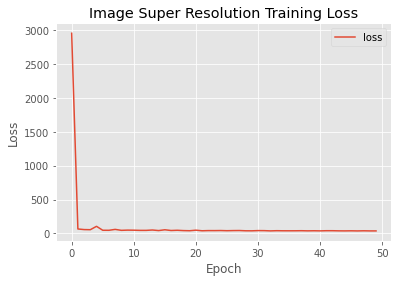

In [7]:
# Plotting the Training Loss
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, config.NUM_EPOCHS), H.history["loss"], label = "loss")
plt.title("Image Super Resolution Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(config.PLOT_PATH)

# Closing the HDF5 Dataset
input_data.close()
target_output.close()

In [8]:
args = {
    "input_img": "jemma.png",
    "baseline": "baseline.png",
    "output_img": "super_resolution.png",
}

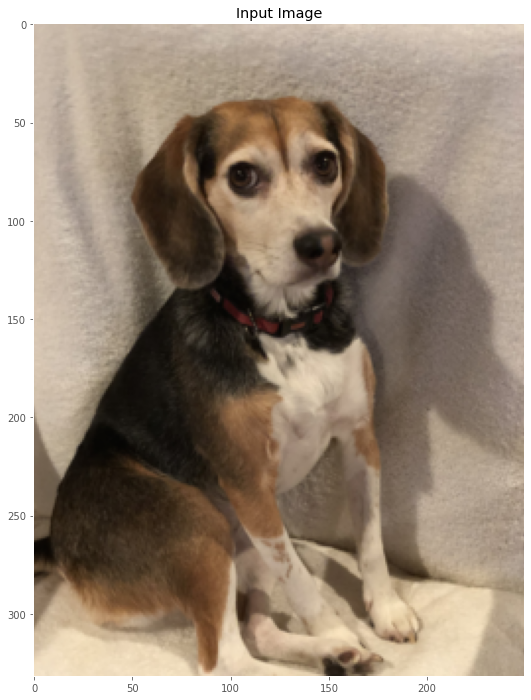

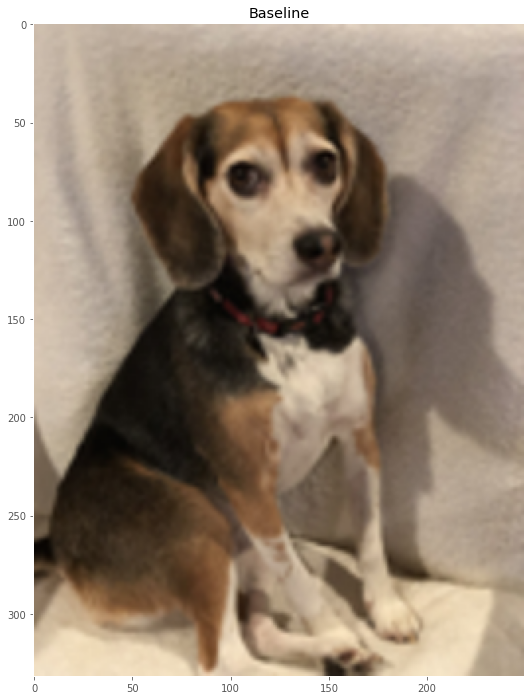

In [9]:
##################### Preprocessing the Image #####################
img = cv2.imread(args["input_img"])
(height, width) = img.shape[:2]
height -= int(height % config.SCALE)
width -= int(width % config.SCALE)
img = img[0:height, 0:width]

# Plotting the Image
display("Input Image", img)

# resize the input image using bicubic interpolation then write the
# baseline image to disk
lowW = int(width * (1.0 / config.SCALE))
lowH = int(height * (1.0 / config.SCALE))
highW = int(lowW * (config.SCALE / 1.0))
highH = int(lowH * (config.SCALE / 1.0))
scaled = np.array(Image.fromarray(img).resize((lowW, lowH), resample=PIL.Image.BICUBIC))
scaled = np.array(Image.fromarray(scaled).resize((highW, highH), resample=PIL.Image.BICUBIC))
cv2.imwrite(args["baseline"], scaled)

# plot the baseline image
display("Baseline", scaled)

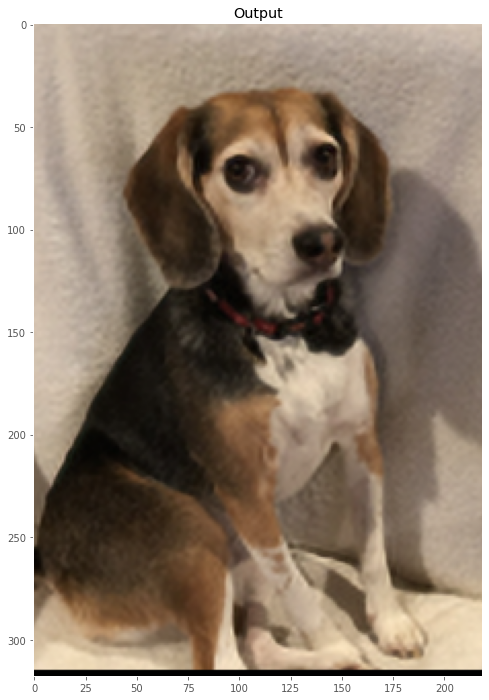

In [10]:
# Loading the Pre-Trained Model
model = load_model(config.MODEL_PATH)

##################### GENERATION OF OUTPUT IMAGE #####################

# allocate memory for the output image
output = np.zeros(scaled.shape)
(h, w) = output.shape[:2]

# slide a window from left-to-right and top-to-bottom
for y in range(0, h - config.INPUT_DIM + 1, config.LABEL_SIZE):
	for x in range(0, w - config.INPUT_DIM + 1, config.LABEL_SIZE):
		# crop ROI from our scaled image
		crop = scaled[y:y + config.INPUT_DIM,
			x:x + config.INPUT_DIM].astype("float32")

		# make a prediction on the crop and store it in our output
		# image
		P = model.predict(np.expand_dims(crop, axis=0))
		P = P.reshape((config.LABEL_SIZE, config.LABEL_SIZE, 3))
		output[y + config.PAD:y + config.PAD + config.LABEL_SIZE,
			x + config.PAD:x + config.PAD + config.LABEL_SIZE] = P

# remove any of the black borders in the output image caused by the
# padding, then clip any values that fall outside the range [0, 255]
output = output[config.PAD:h - ((h % config.INPUT_DIM) + config.PAD),
	config.PAD:w - ((w % config.INPUT_DIM) + config.PAD)]
output = np.clip(output, 0, 255).astype("uint8")

# write the output image to disk
cv2.imwrite(args["output_img"], output)

# plot the output of the model
display("Output", output)